In [260]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import intvalpy as ip

In [261]:
def is_tolerance_set_empty(A, b):
  max_tol = ip.linear.Tol.maximize(A, b)
  return max_tol[1] < 0, max_tol[0]

In [262]:
def b_correction(b, k):
  e = ip.Interval([[-k, k] for i in range(len(b))])
  return b + e

In [263]:
def find_b_correction_min_K(A, b, eps=10e-3, max_iterations=1000):
  prev_k = 0
  cur_k = 0
  iteration = 0
  corrected_b = b
  is_empty, _ = is_tolerance_set_empty(A, corrected_b)

  while is_empty and iteration <= max_iterations:
    prev_k = cur_k
    cur_k = math.exp(iteration)
    corrected_b = b_correction(b, cur_k)
    is_empty, _ = is_tolerance_set_empty(A, corrected_b)
    iteration += 1

  if is_empty:
    raise Exception('Could not find K for b-correction')

  iteration = 0

  while abs(prev_k - cur_k) > eps and iteration <= max_iterations:
    mid_k = (prev_k + cur_k) / 2

    corrected_b = b_correction(b, mid_k)
    is_empty, _ = is_tolerance_set_empty(A, corrected_b)

    if is_empty:
      prev_k = mid_k
    else:
      cur_k = mid_k

    iteration += 1

  corrected_b = b_correction(b, cur_k)

  return corrected_b, cur_k, iteration

In [264]:
def A_correction(A, b):
  max_tol = ip.linear.Tol.maximize(A, b)
  lower_bound = abs(max_tol[1]) / (abs(max_tol[0][0]) + abs(max_tol[0][1]))

  rad_A = ip.rad(A)
  upper_bound = rad_A[0][0]

  for a_i in rad_A:
    for a_ij in a_i:
      if a_ij < upper_bound:
        upper_bound = a_ij
  e = (lower_bound + upper_bound) / 2
  corrected_A = []

  for i in range(len(A)):
    A_i = []

    for j in range(len(A[0])):
      A_i.append([A[i][j]._a + e, A[i][j]._b - e])

    corrected_A.append(A_i)

  return ip.Interval(corrected_A)

In [265]:
def plot_tol(axis, A, b):
  max_tol = ip.linear.Tol.maximize(A, b)

  grid_min, grid_max = max_tol[0][0] - 2, max_tol[0][0] + 2
  x_1_, x_2_ = np.mgrid[grid_min:grid_max:100j, grid_min:grid_max:100j]
  list_x_1 = np.linspace(grid_min, grid_max, 100)
  list_x_2 = np.linspace(grid_min, grid_max, 100)

  list_tol = np.zeros((100, 100))

  for idx_x1, x1 in enumerate(list_x_1):
    for idx_x2, x2 in enumerate(list_x_2):
      x = [x1, x2]
      tol_values = []

      for i in range(len(b)):
        sum_ = sum(A[i][j] * x[j] for j in range(len(x)))
        rad_b, mid_b = ip.rad(b[i]), ip.mid(b[i])
        tol = rad_b - ip.mag(mid_b - sum_)
        tol_values.append(tol)

      list_tol[idx_x1, idx_x2] = min(tol_values)

  axis.view_init(elev=30, azim=45)
  axis.plot_surface(x_1_, x_2_, list_tol, cmap='plasma')
  axis.scatter(*max_tol[0], max_tol[1], color='red', s=50)

In [266]:
def plot_tol_functional(axis, A, b):
  max_tol = ip.linear.Tol.maximize(A, b)
  solution = max_tol[0]

  x = np.linspace(float(solution[0]) - 2, float(solution[0]) + 2, 401)
  y = np.linspace(float(solution[1]) -2, float(solution[1]) + 2, 401)
  xx, yy = np.meshgrid(x, y)
  zz = np.array([[1 if ip.linear.Tol.value(A, b, [x, y]) >= 0 else 0 for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xx, yy)])

  axis.contourf(xx, yy, zz, levels=1, colors=['lightcoral', 'lightgreen'])
  axis.scatter(solution[0], solution[1], color='red', marker='x', s=50)
  axis.set_xlabel('x₁')
  axis.set_ylabel('x₂')

In [267]:
A_1 = ip.Interval([
  [[0.65, 1.25], [0.70, 1.3]],
  [[0.75, 1.35], [0.70, 1.3]]
])
b_1 = ip.Interval([
  [2.75, 3.15],
  [2.85, 3.25],
])

A_2 = ip.Interval([
  [[0.65, 1.25], [0.70, 1.3]],
  [[0.75, 1.35], [0.70, 1.3]],
  [[0.8, 1.4], [0.70, 1.3]],
])
b_2 = ip.Interval([
  [2.75, 3.15],
  [2.85, 3.25],
  [2.90, 3.3],
])

A_3 = ip.Interval([
  [[0.65, 1.25], [0.70, 1.3]],
  [[0.75, 1.35], [0.70, 1.3]],
  [[0.8, 1.4], [0.70, 1.3]],
  [[-0.3, 0.3], [0.70, 1.3]],
])
b_3 = ip.Interval([
  [2.75, 3.15],
  [2.85, 3.25],
  [2.90, 3.3],
  [1.8, 2.2],
])

systems = (
  (A_1, b_1),
  (A_2, b_2),
  (A_3, b_3),
)

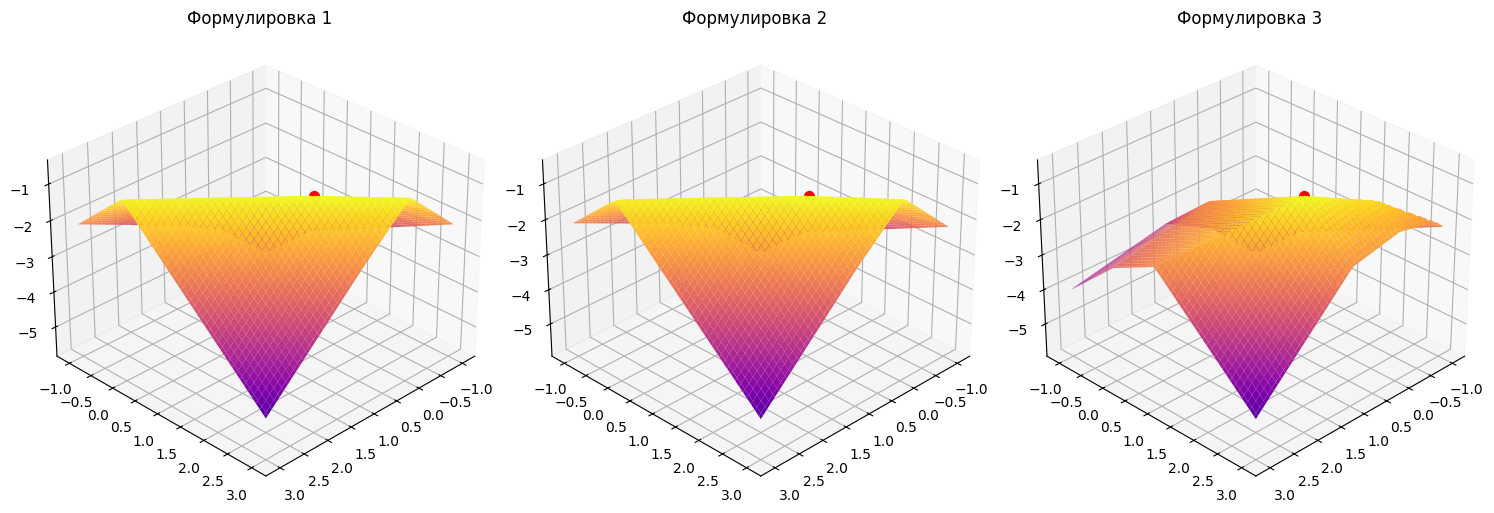

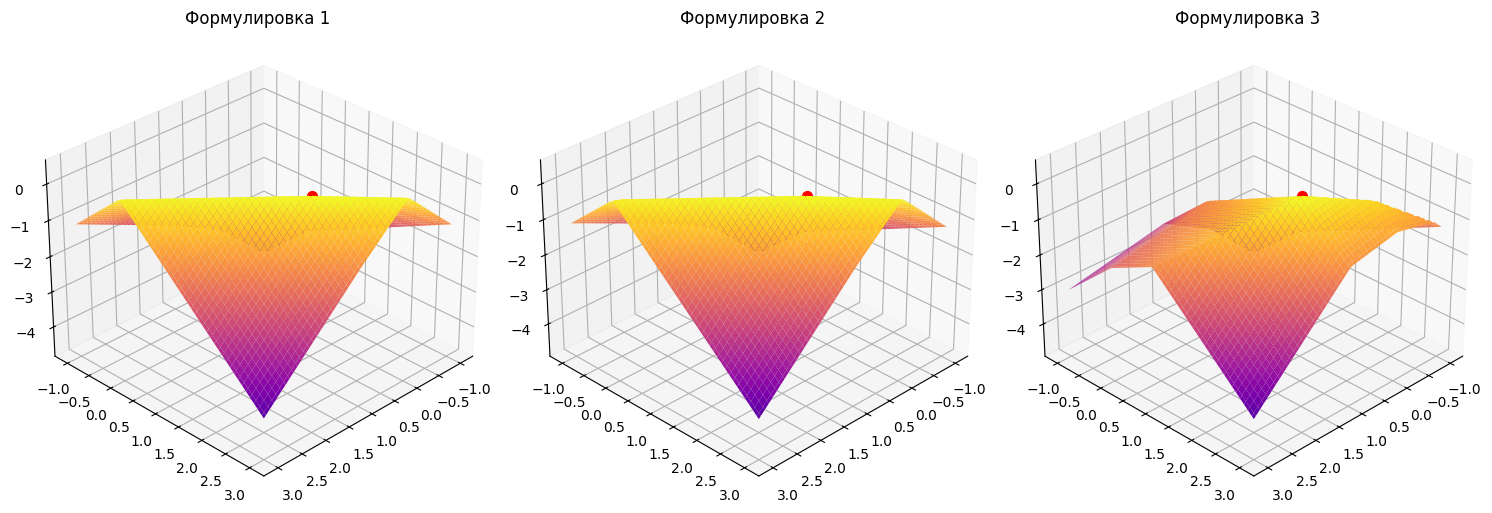

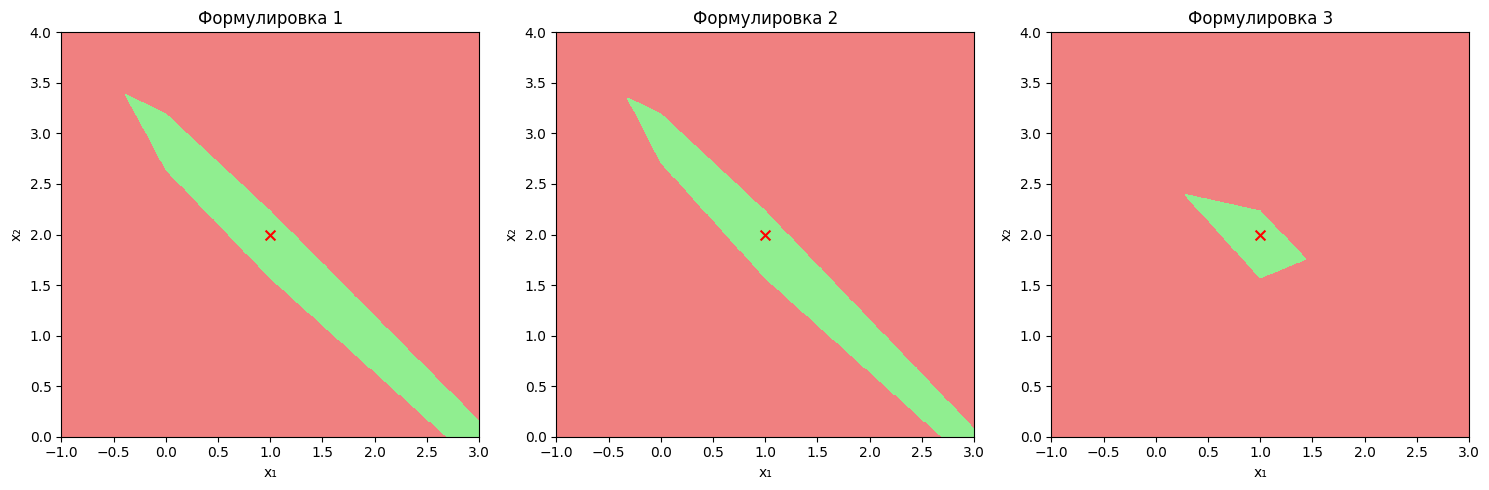

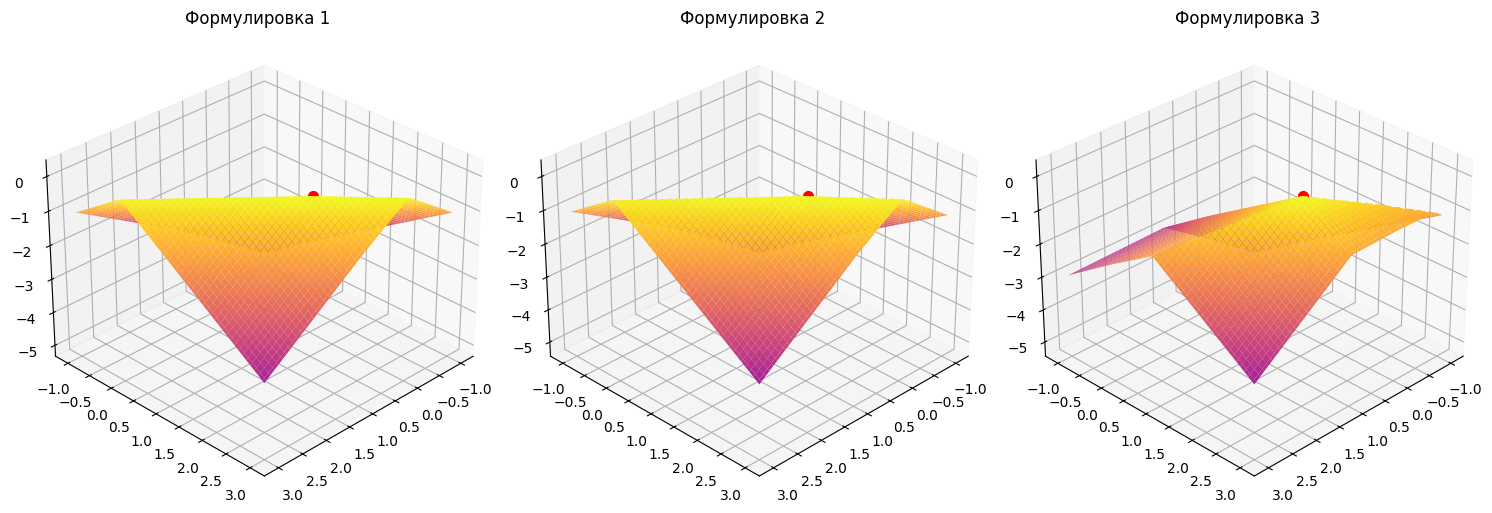

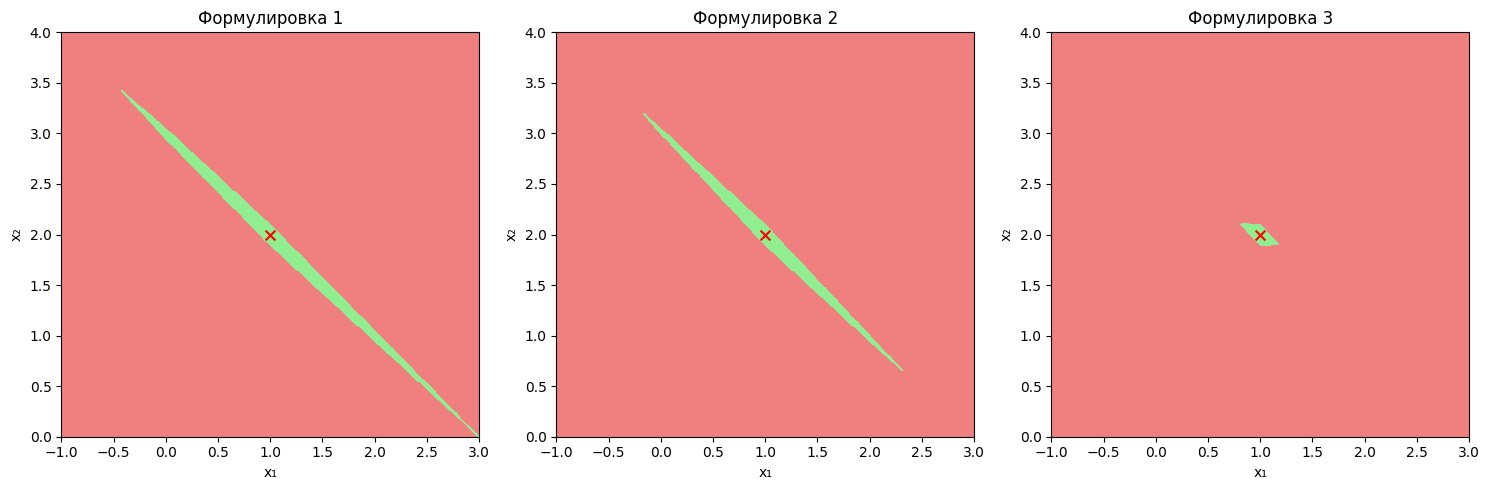

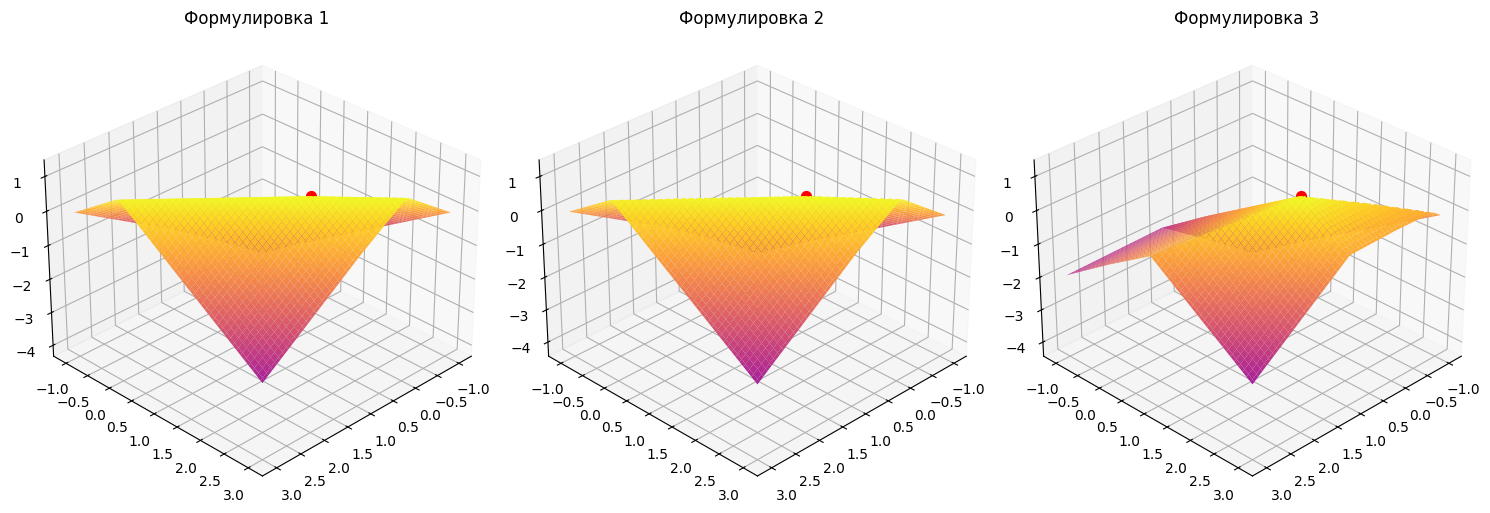

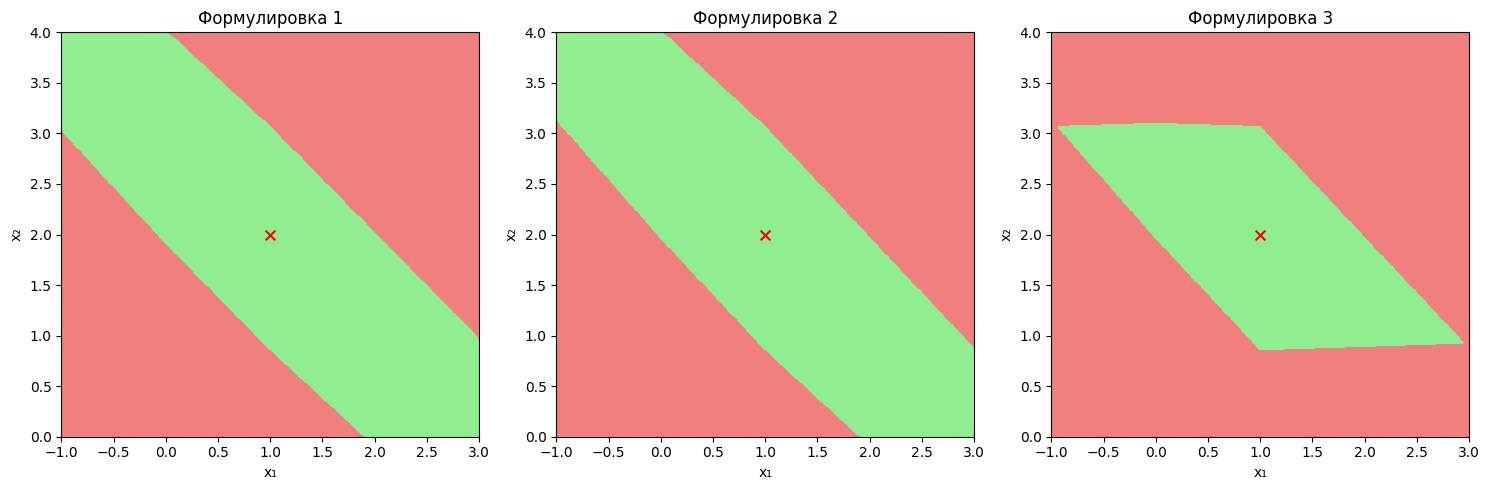

In [268]:
fig_raw = plt.figure(figsize=(15, 5))

fig_b_corrected = plt.figure(figsize=(15, 5))
fig_b_corrected_2d = plt.figure(figsize=(15, 5))

fig_a_corrected = plt.figure(figsize=(15, 5))
fig_a_corrected_2d = plt.figure(figsize=(15, 5))

fig_ab_corrected = plt.figure(figsize=(15, 5))
fig_ab_corrected_2d = plt.figure(figsize=(15, 5))

for index, (A, b) in enumerate(systems):
  axis_raw = fig_raw.add_subplot(131 + index, projection='3d')
  axis_raw.set_title(f'Формулировка {index + 1}')
  plot_tol(axis_raw, A, b)

  b_corrected = b_correction(b, 1)

  axis_b_corrected = fig_b_corrected.add_subplot(131 + index, projection='3d')
  axis_b_corrected.set_title(f'Формулировка {index + 1}')
  plot_tol(axis_b_corrected, A, b_corrected)

  axis_b_corrected_2d = fig_b_corrected_2d.add_subplot(131 + index)
  axis_b_corrected_2d.set_title(f'Формулировка {index + 1}')
  plot_tol_functional(axis_b_corrected_2d, A, b_corrected)

  A_corrected = A_correction(A, b)

  axis_a_corrected = fig_a_corrected.add_subplot(131 + index, projection='3d')
  axis_a_corrected.set_title(f'Формулировка {index + 1}')
  plot_tol(axis_a_corrected, A_corrected, b)

  axis_a_corrected_2d = fig_a_corrected_2d.add_subplot(131 + index)
  axis_a_corrected_2d.set_title(f'Формулировка {index + 1}')
  plot_tol_functional(axis_a_corrected_2d, A_corrected, b)

  axis_ab_corrected = fig_ab_corrected.add_subplot(131 + index, projection='3d')
  axis_ab_corrected.set_title(f'Формулировка {index + 1}')
  plot_tol(axis_ab_corrected, A_corrected, b_corrected)

  axis_ab_corrected_2d = fig_ab_corrected_2d.add_subplot(131 + index)
  axis_ab_corrected_2d.set_title(f'Формулировка {index + 1}')
  plot_tol_functional(axis_ab_corrected_2d, A_corrected, b_corrected)

fig_raw.tight_layout()
fig_b_corrected.tight_layout()
fig_b_corrected_2d.tight_layout()
fig_a_corrected.tight_layout()
fig_a_corrected_2d.tight_layout()
fig_ab_corrected.tight_layout()
fig_ab_corrected_2d.tight_layout()